In [1]:
%pwd

'c:\\Users\\yashr\\OneDrive\\Desktop\\CMI_detect_sleep_states\\CMI-sleep-state-detection\\research'

In [2]:
import os 
os.chdir("..")

In [3]:
%pwd

'c:\\Users\\yashr\\OneDrive\\Desktop\\CMI_detect_sleep_states\\CMI-sleep-state-detection'

In [5]:
import pandas as pd
import pyarrow.parquet as pq

train_series = pq.read_table("data/train_series.parquet").to_pandas()
train_events = pd.read_csv("data/train_events.csv")

In [6]:
train_series

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215
...,...,...,...,...,...
127946335,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.277500,0.0204
127946336,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.032499,0.0233
127946337,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.841200,0.0202
127946338,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.723900,0.0199


In [7]:
train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14506,fe90110788d2,35,onset,NaN,NaN


In [8]:
series_ids = train_events['series_id'].unique()


038441c925bb


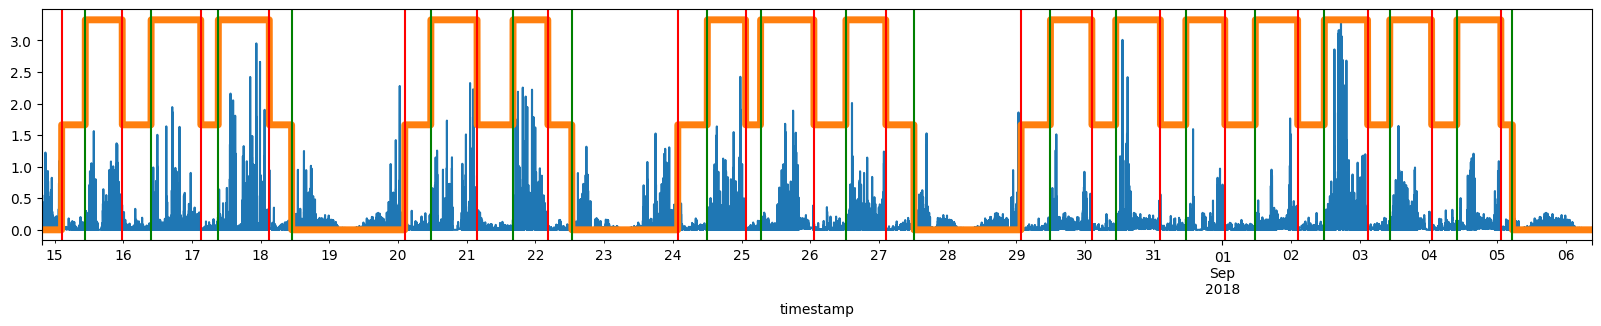


03d92c9f6f8a


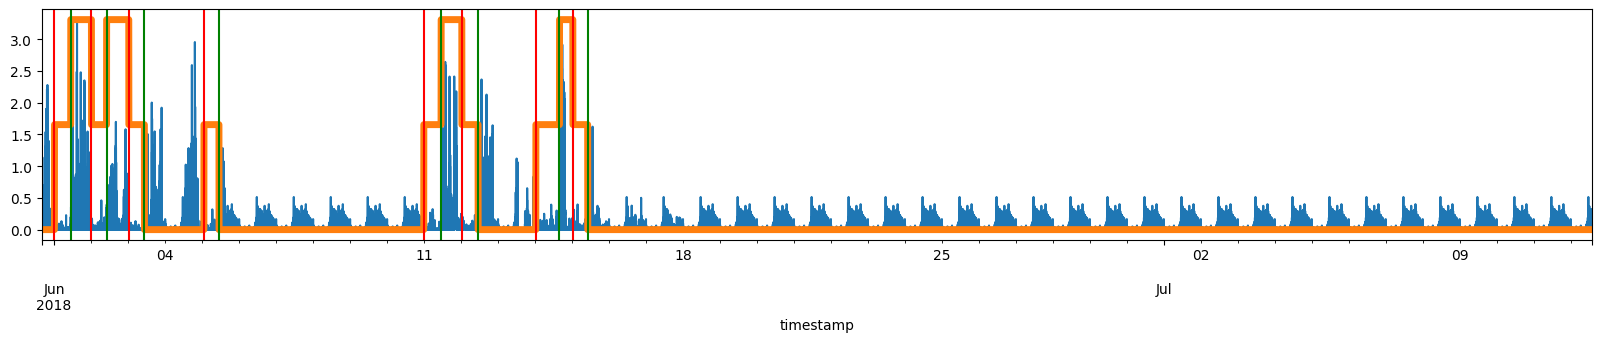


0402a003dae9


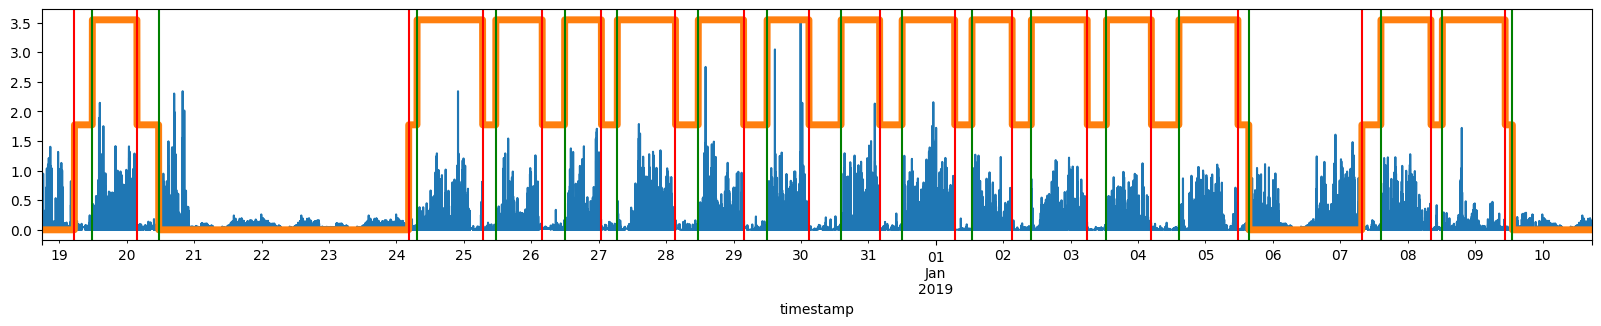


04f547b8017d


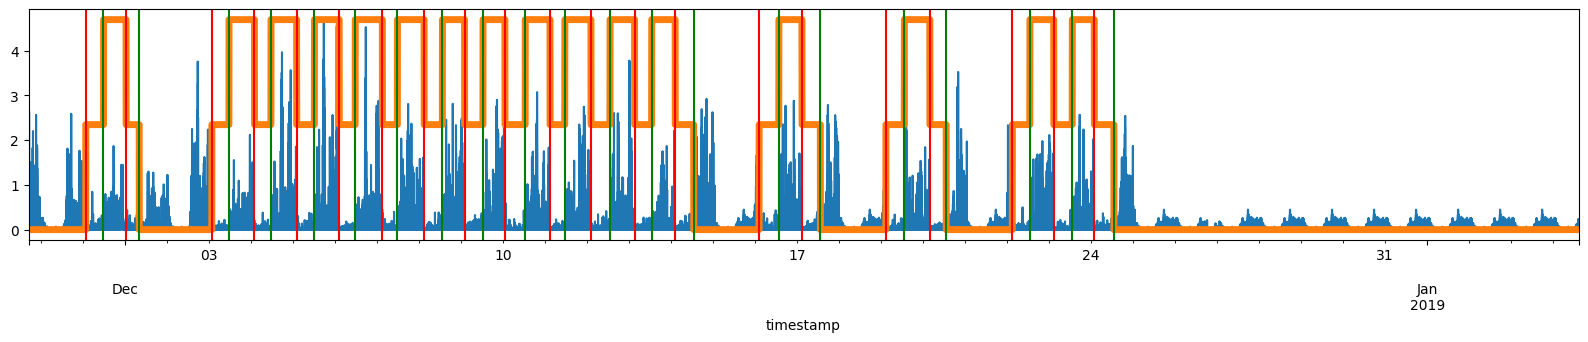


05e1944c3818


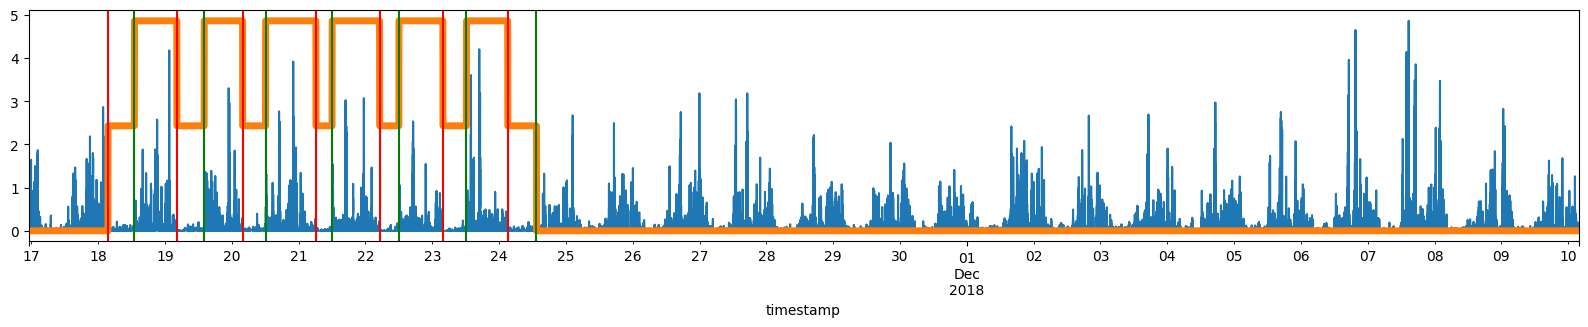


062cae666e2a


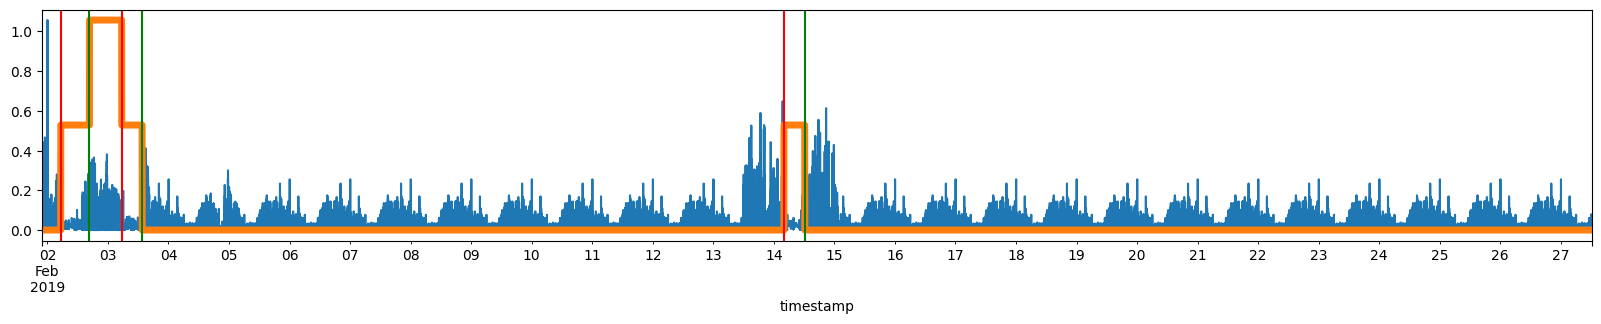


062dbd4c95e6


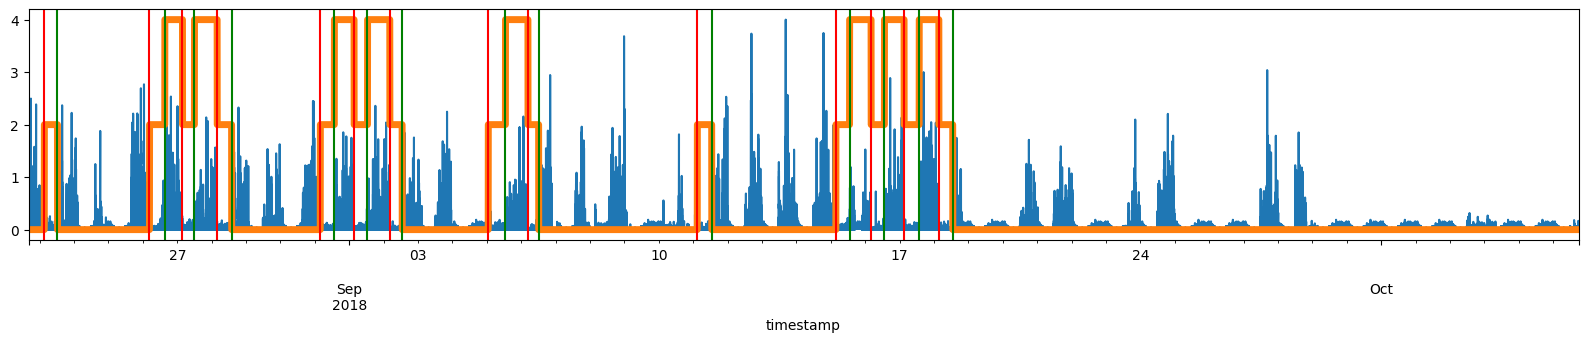


08db4255286f


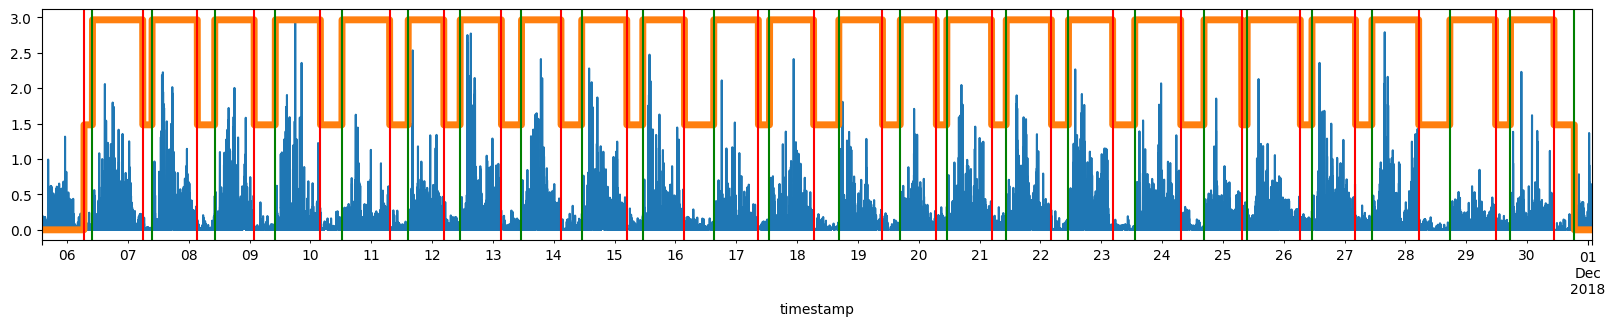


0a96f4993bd7


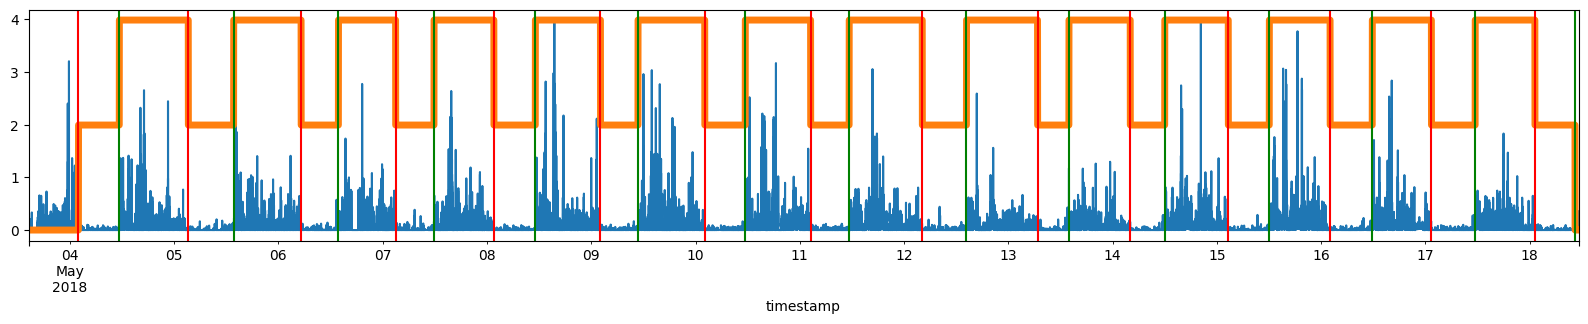


0cd1e3d0ed95


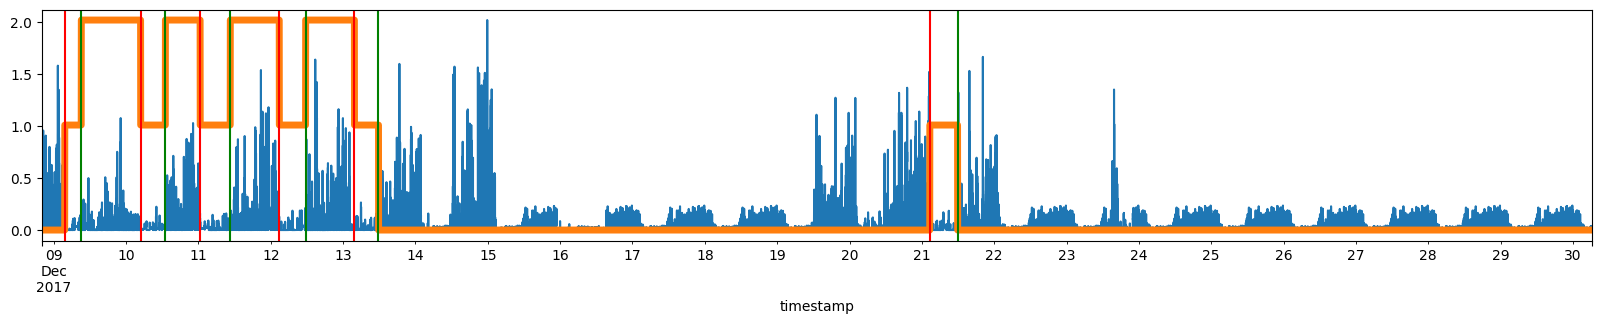


0ce74d6d2106


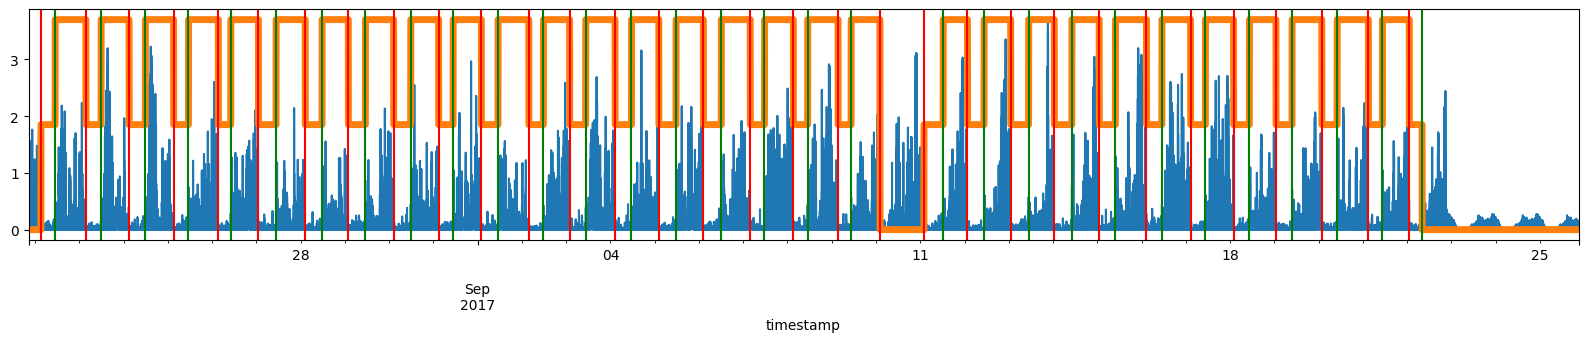


0cfc06c129cc


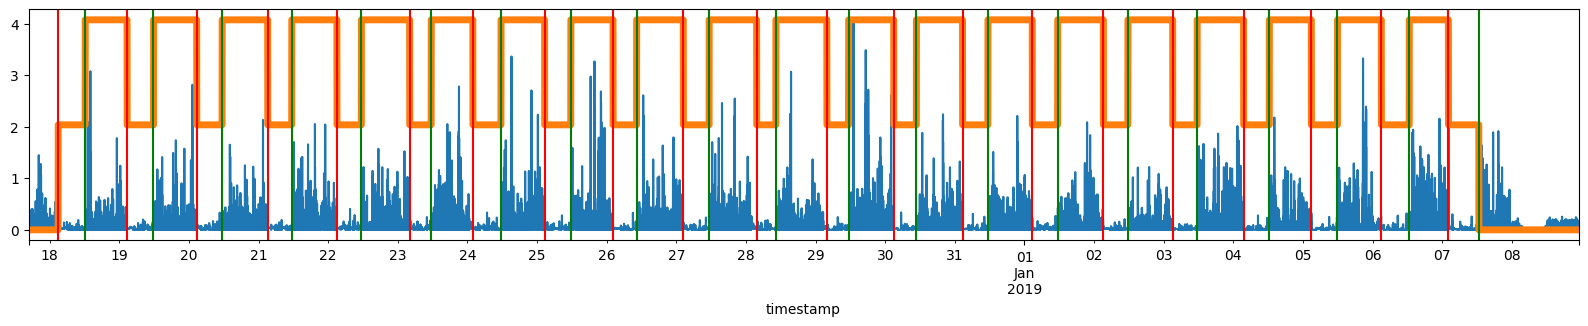


0d0ad1e77851


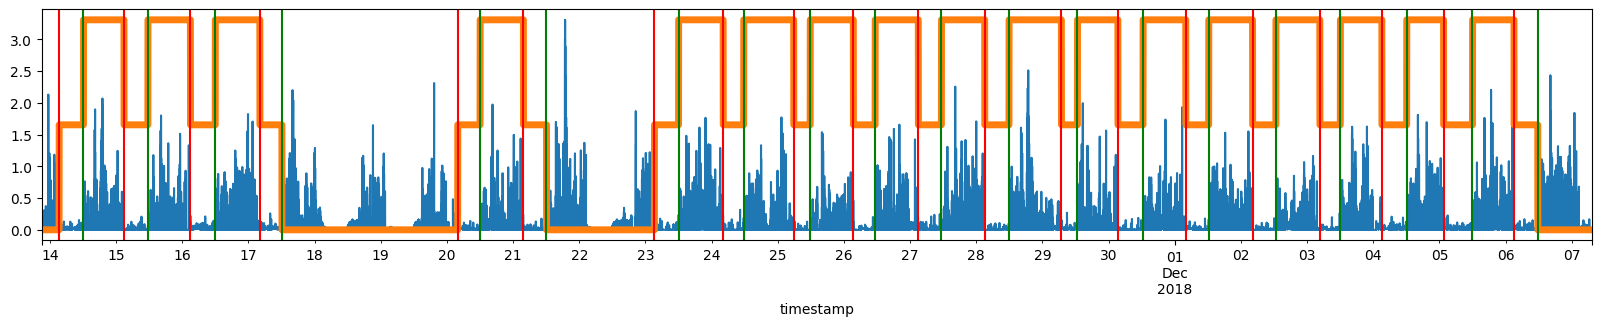


0dee4fda51c3


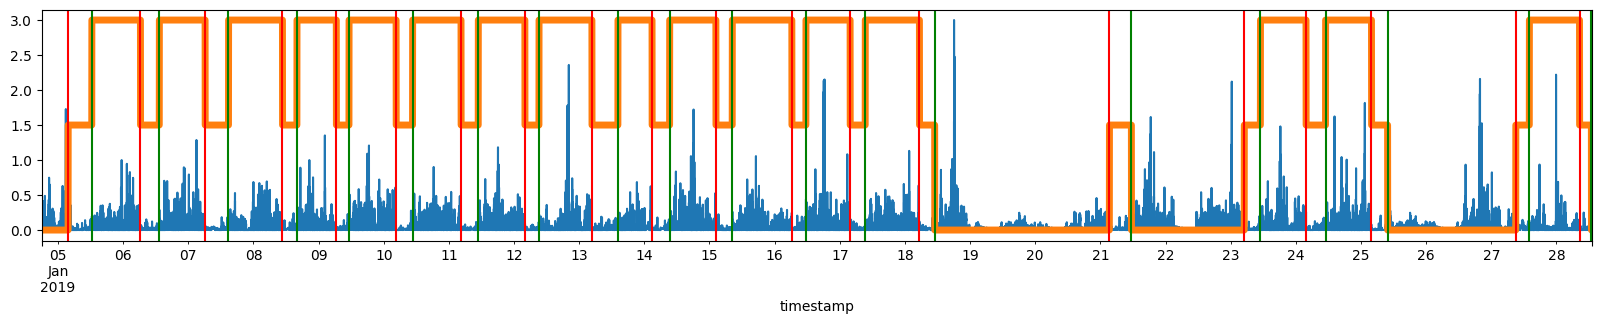


0ec9fc461819


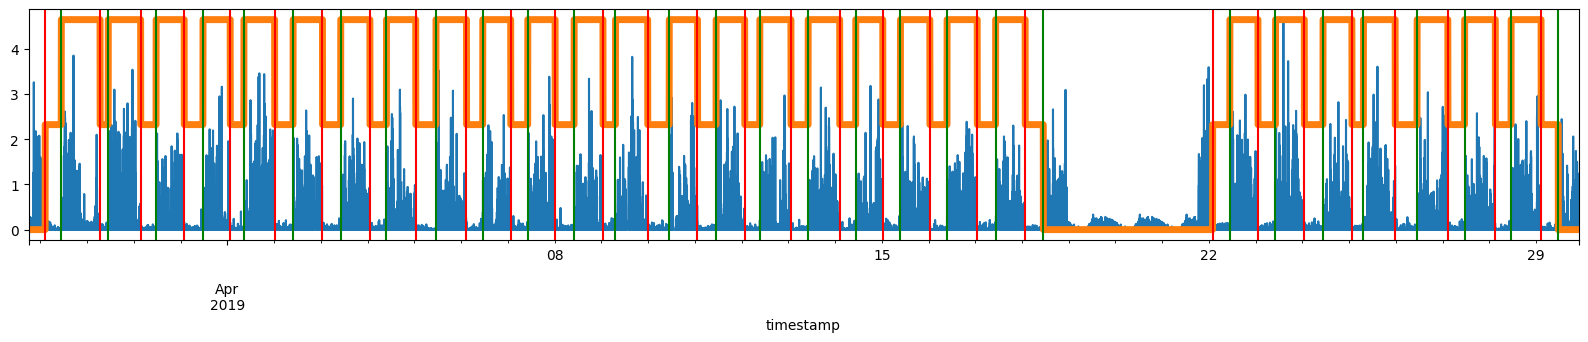


0ef7d94fde99


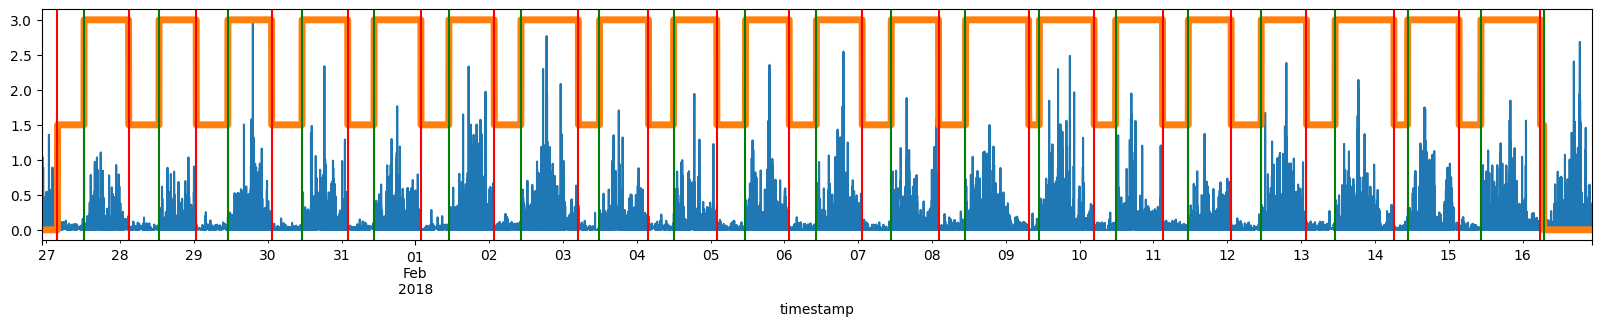


0f572d690310


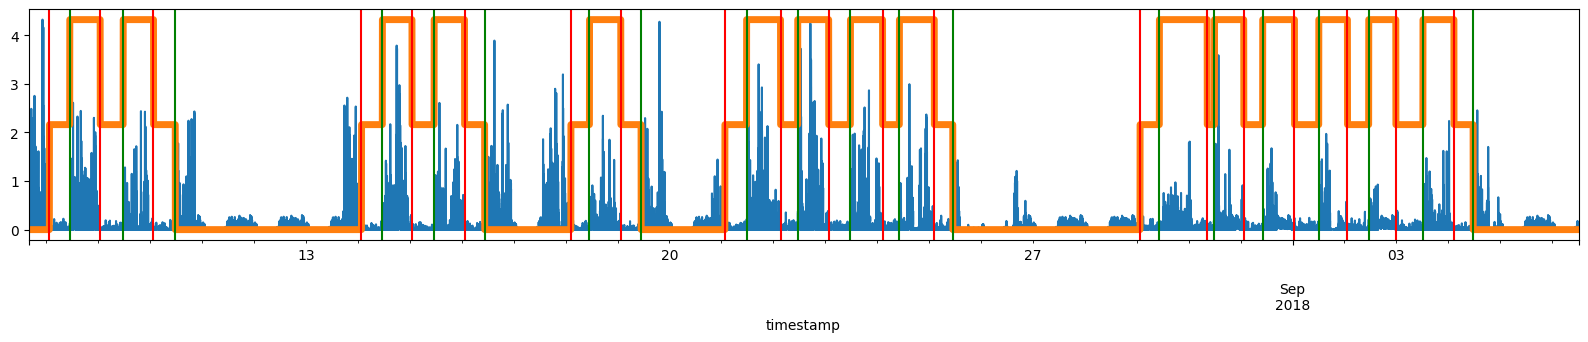


0f9e60a8e56d


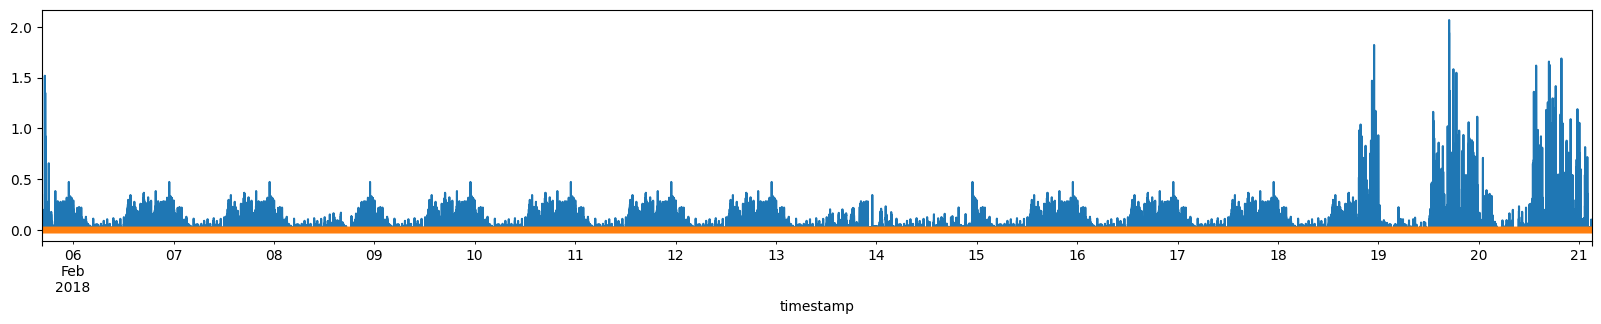


10469f6765bf


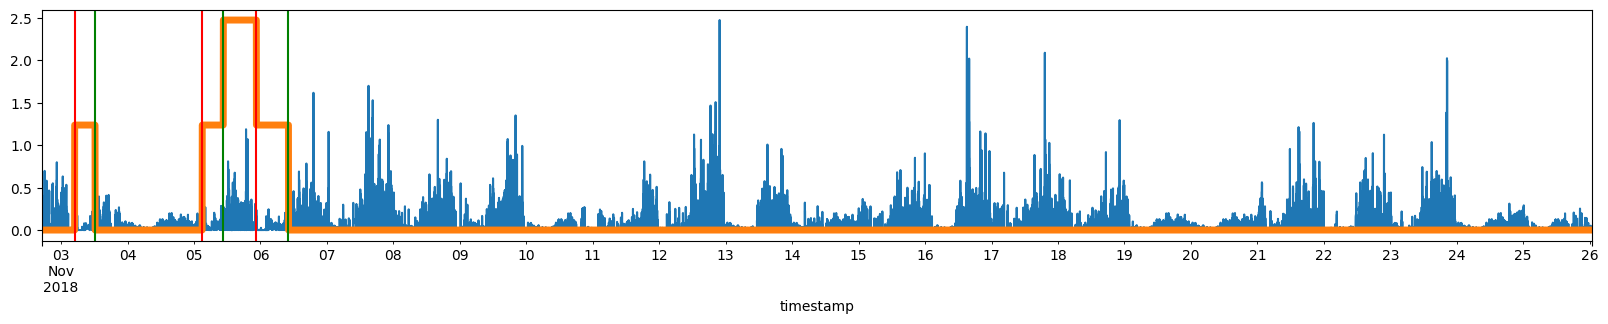


1087d7b0ff2e


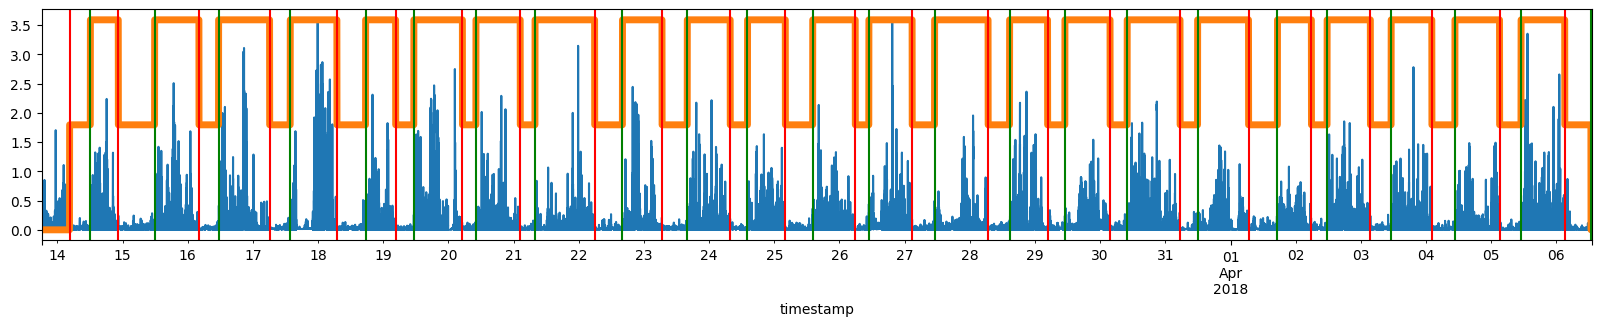


10f8bc1f7b07


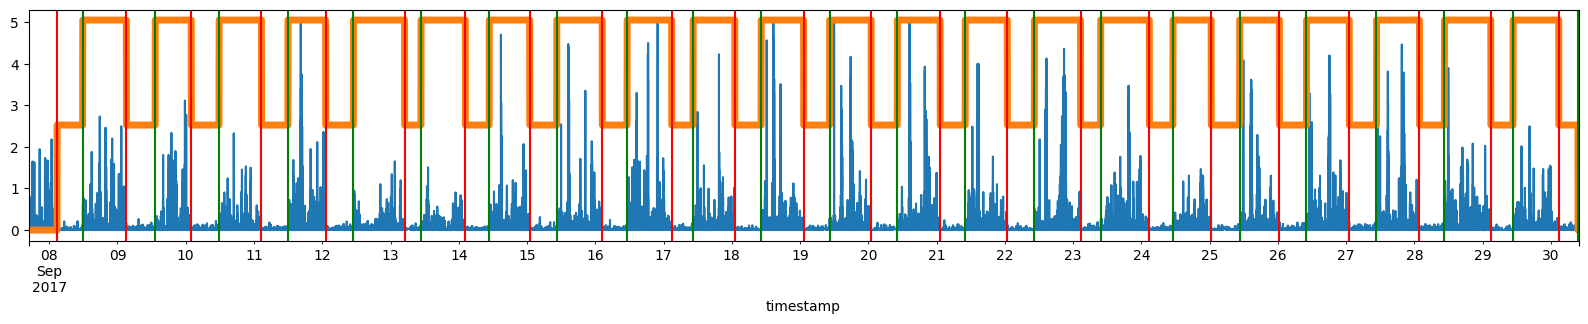


12d01911d509


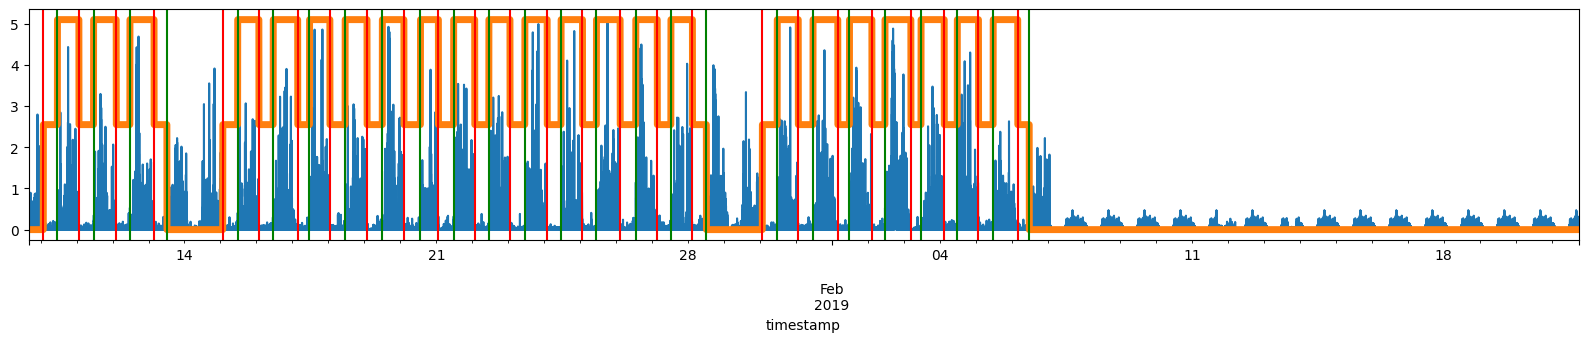


1319a1935f48


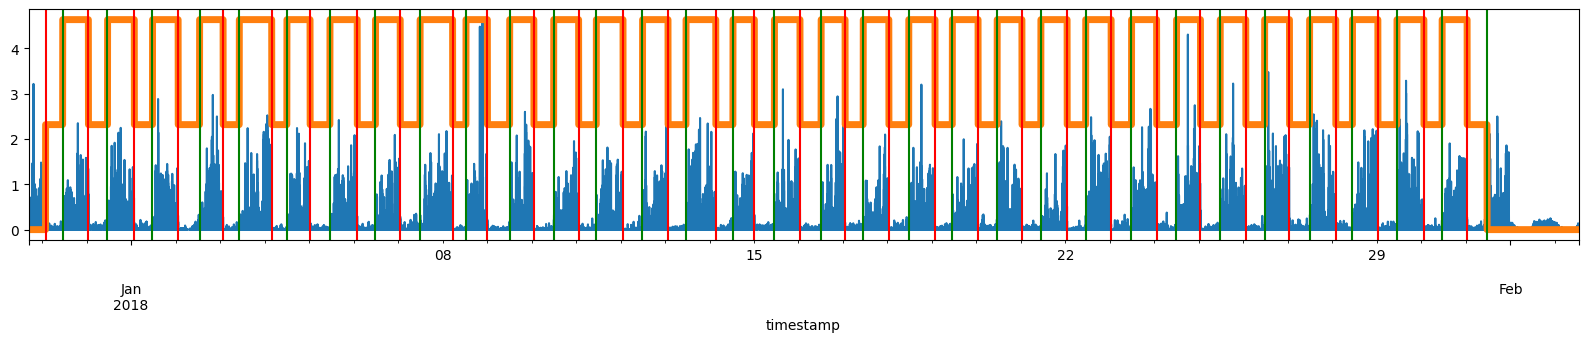


137771d19ca2


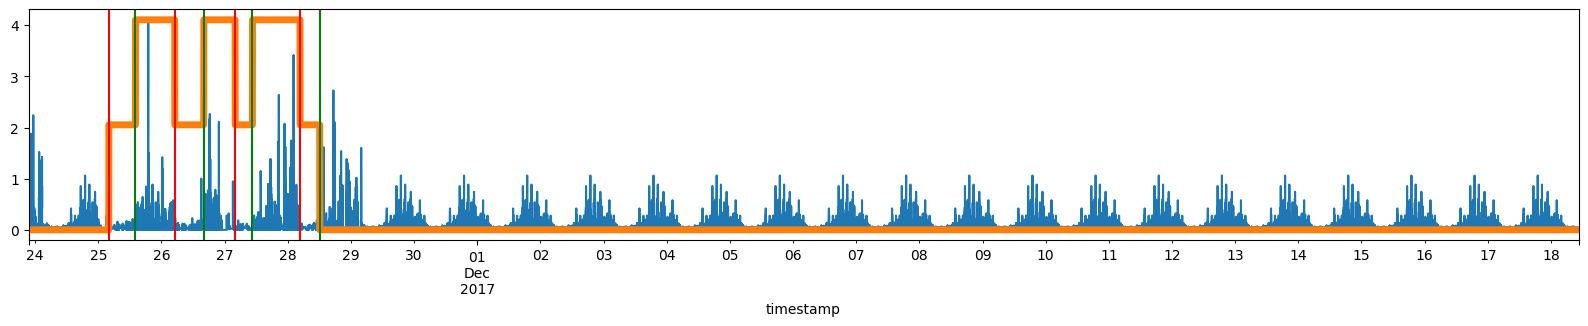


137b99e936ab


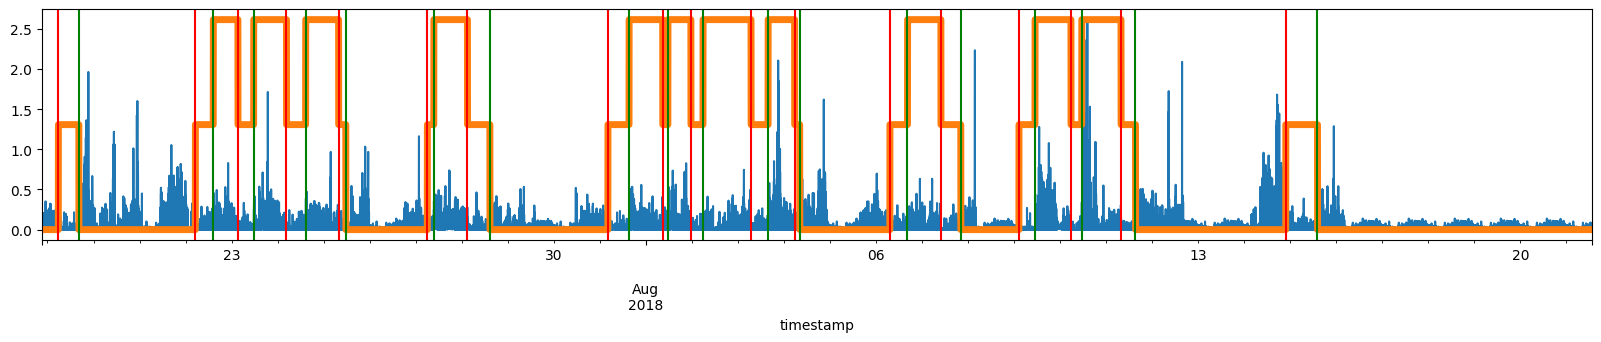


13b4d6a01d27


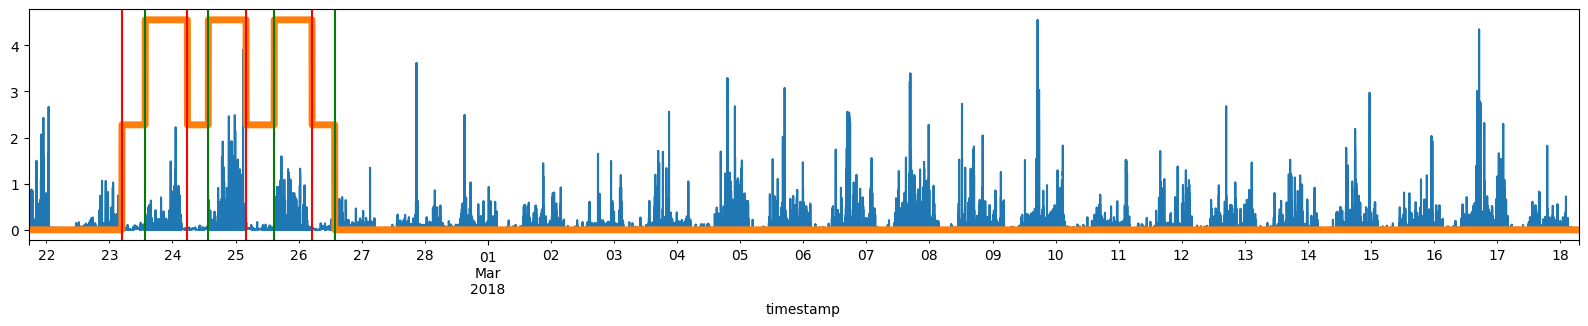


148471991ffb


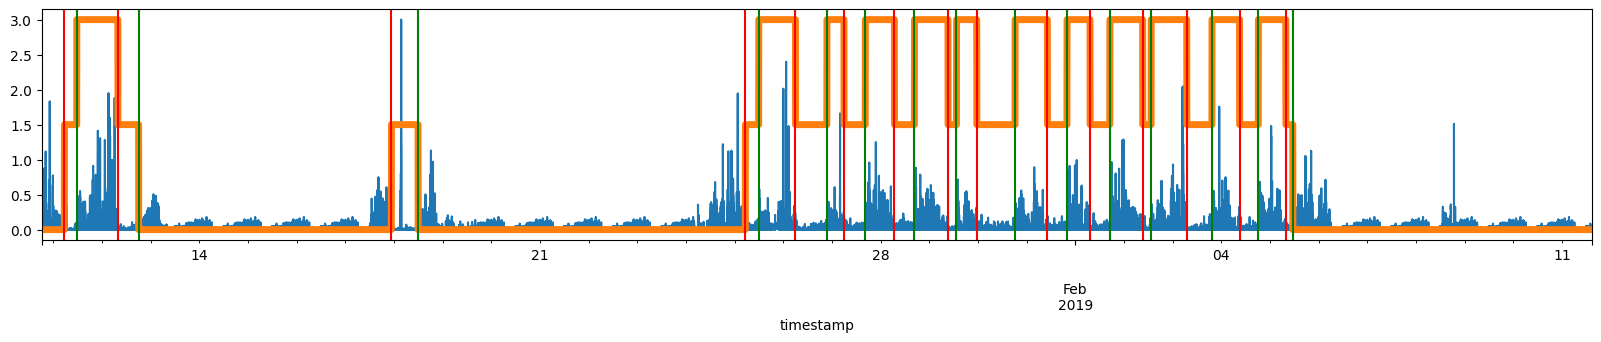


154fe824ed87


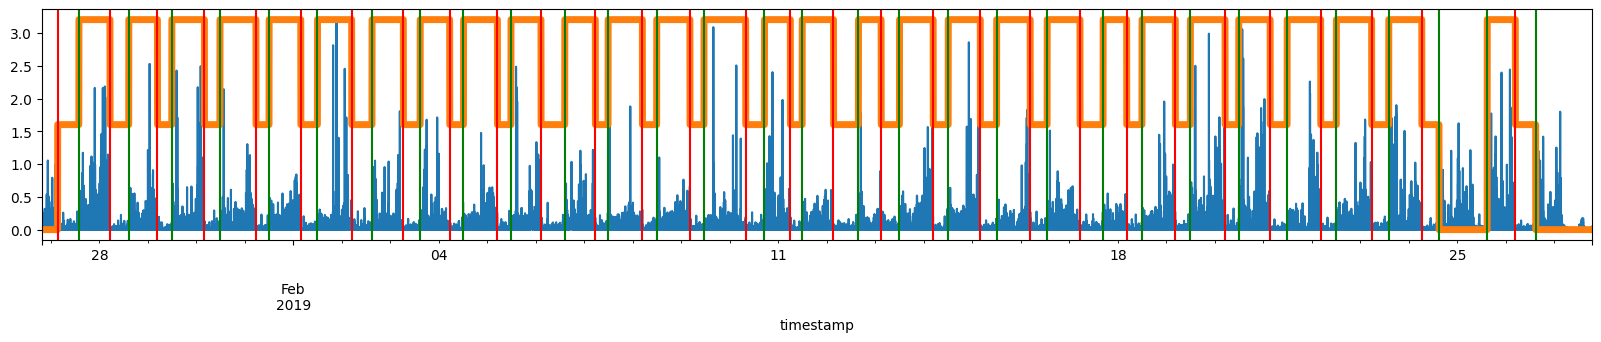


16fe2798ed0f


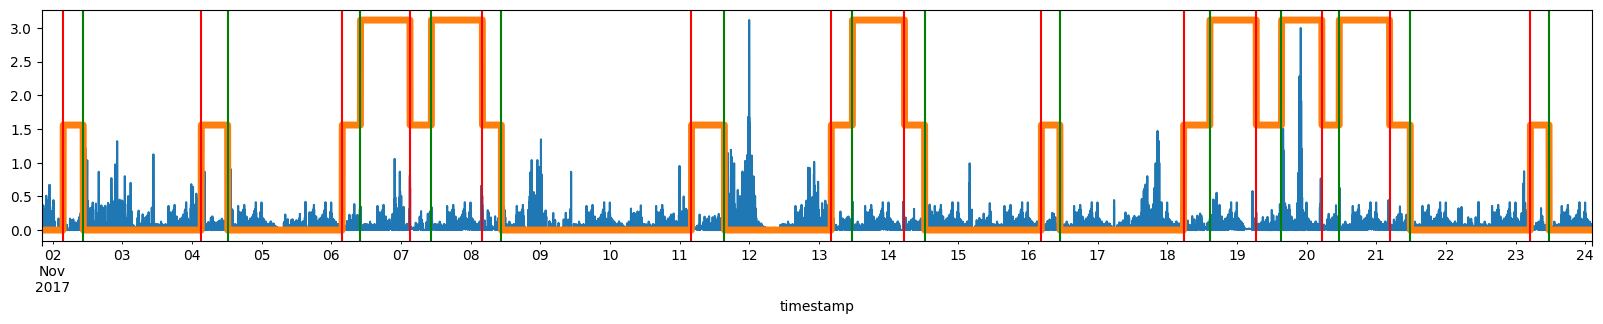


1716cd4163b2


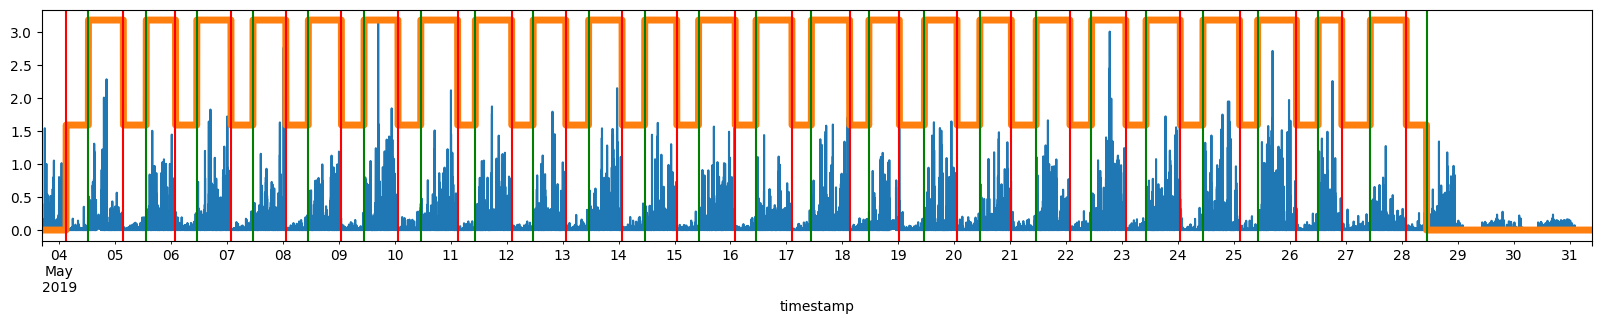


1762ab70ec76


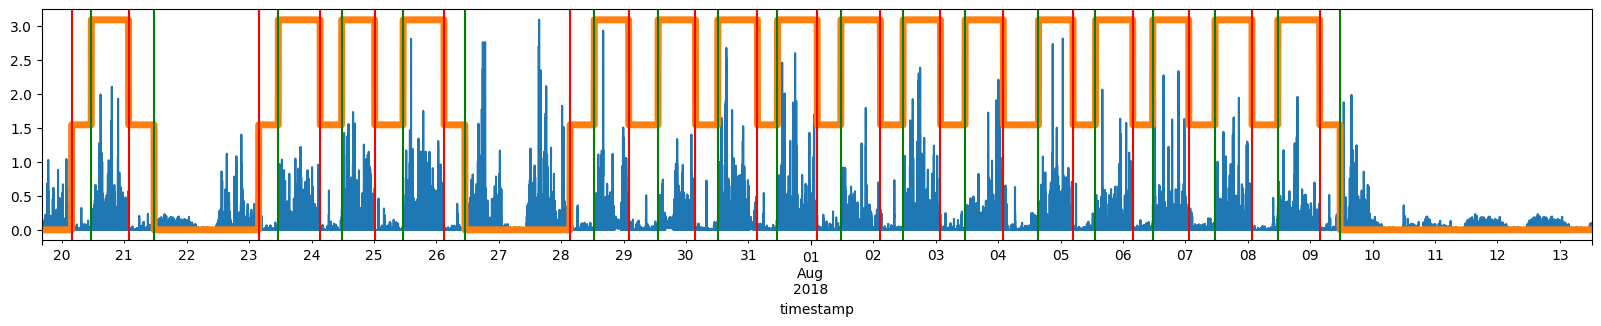


188d4b7cd28b


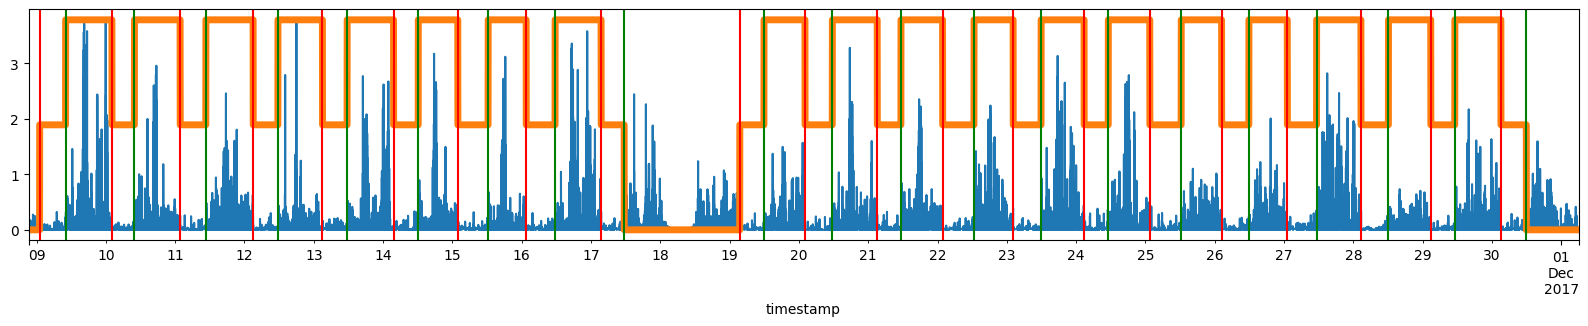


18a0ca03431d


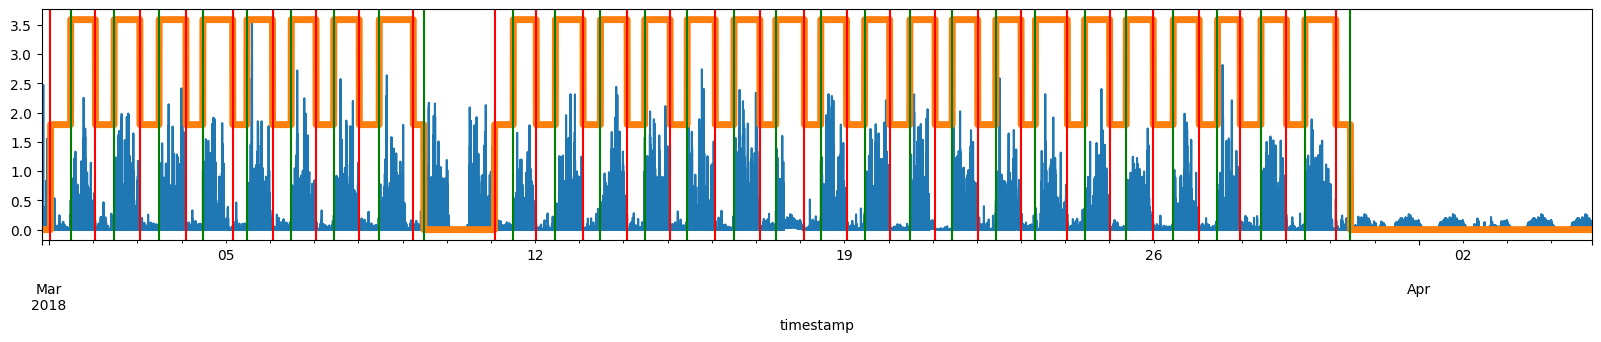


18b61dd5aae8


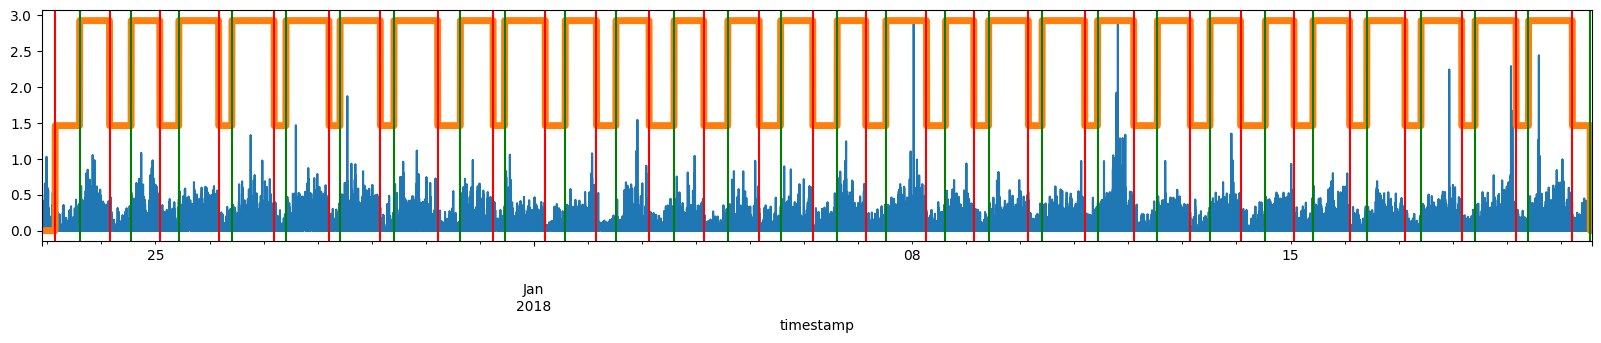


1955d568d987


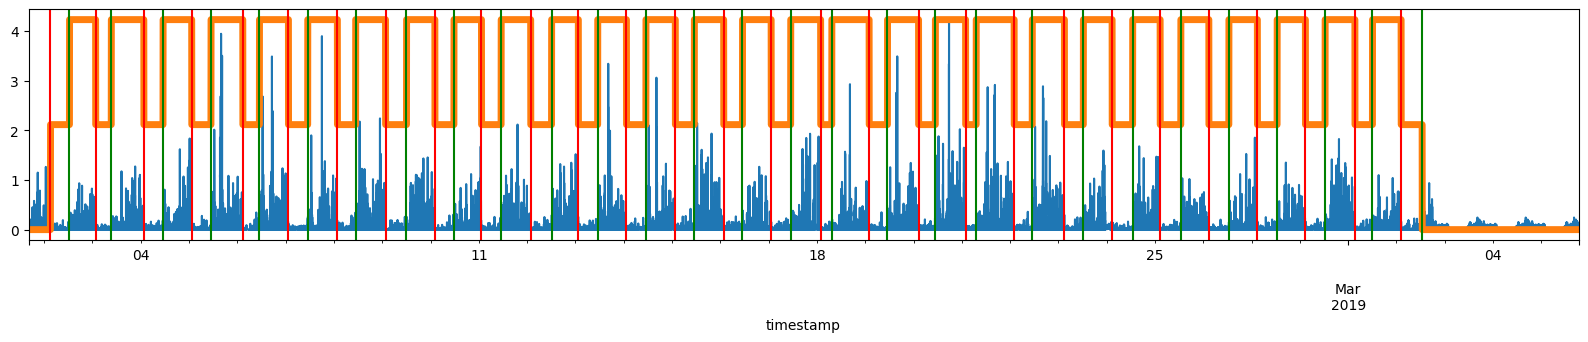


1b92be89db4c


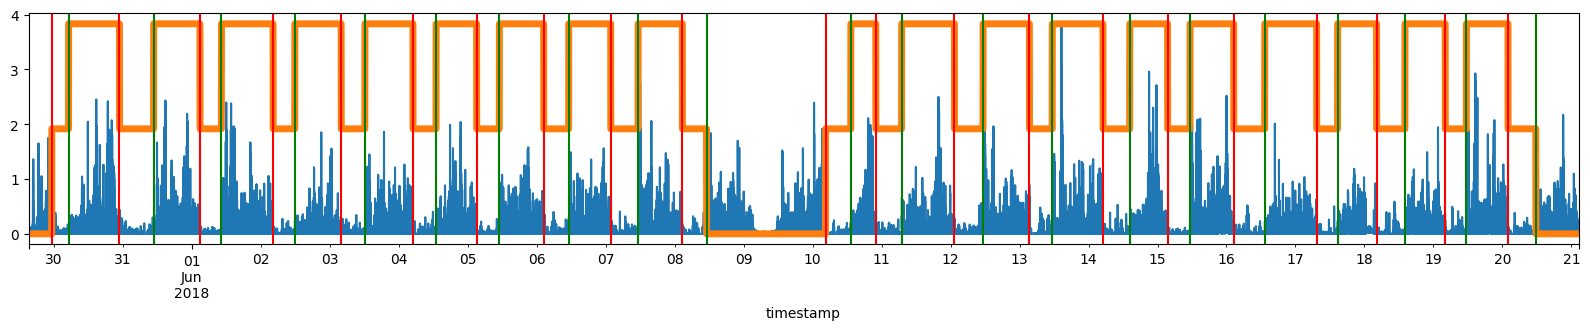


1c7c0bad1263


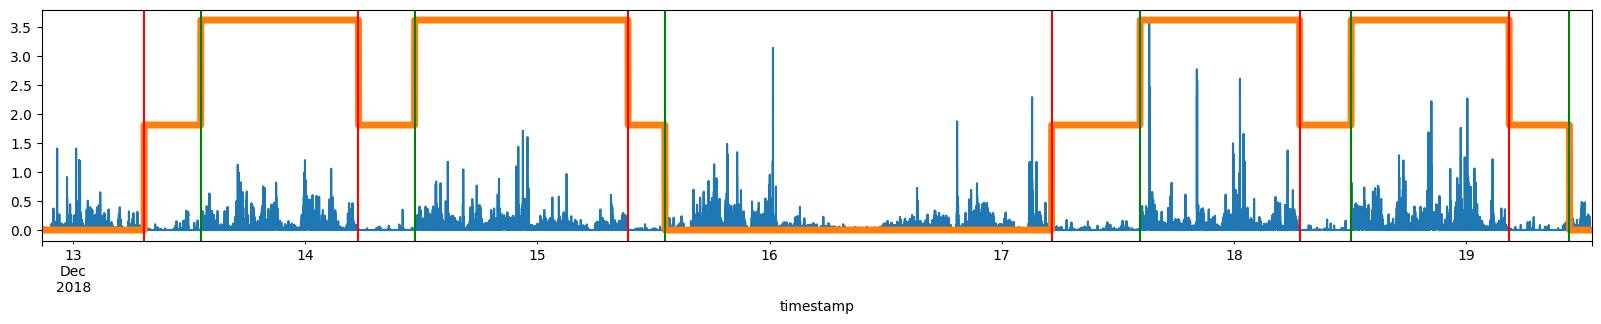


1d4569cbac0f


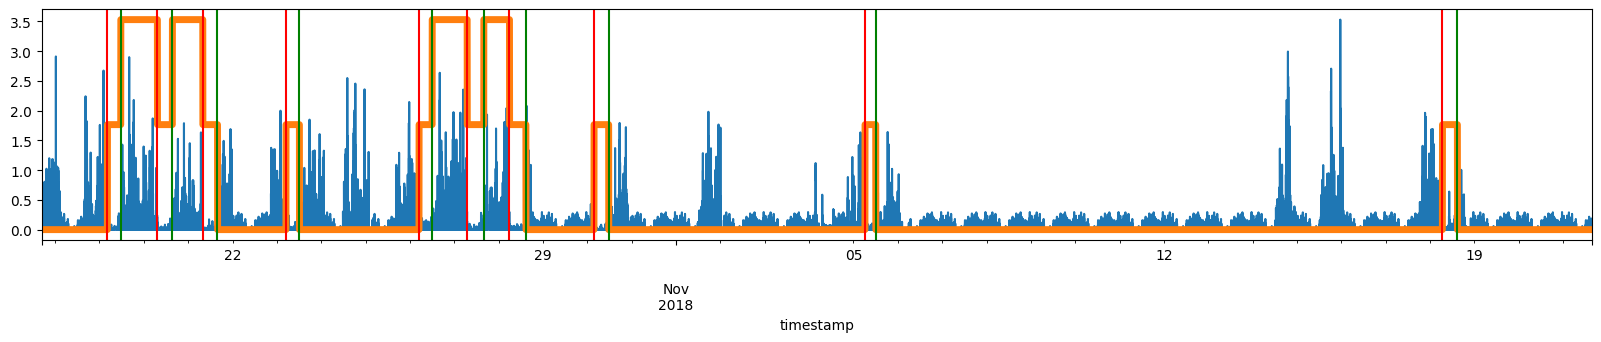


1e6717d93c1d


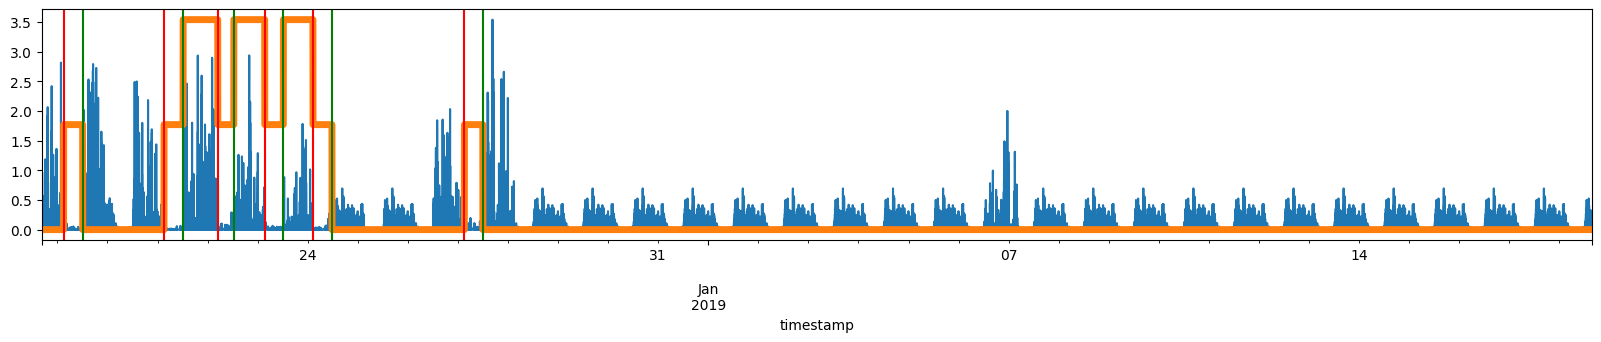


1f96b9668bdf


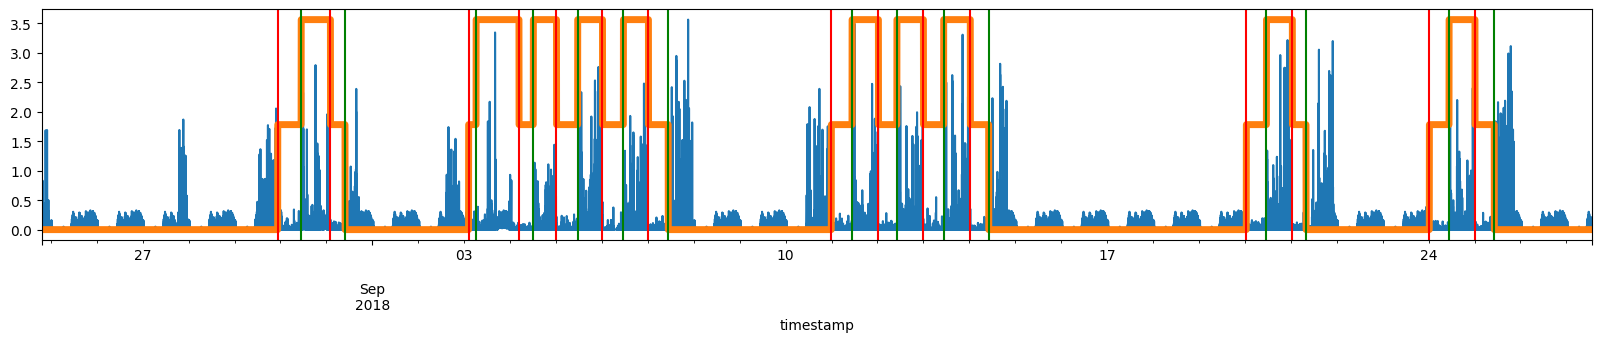


207eded97727


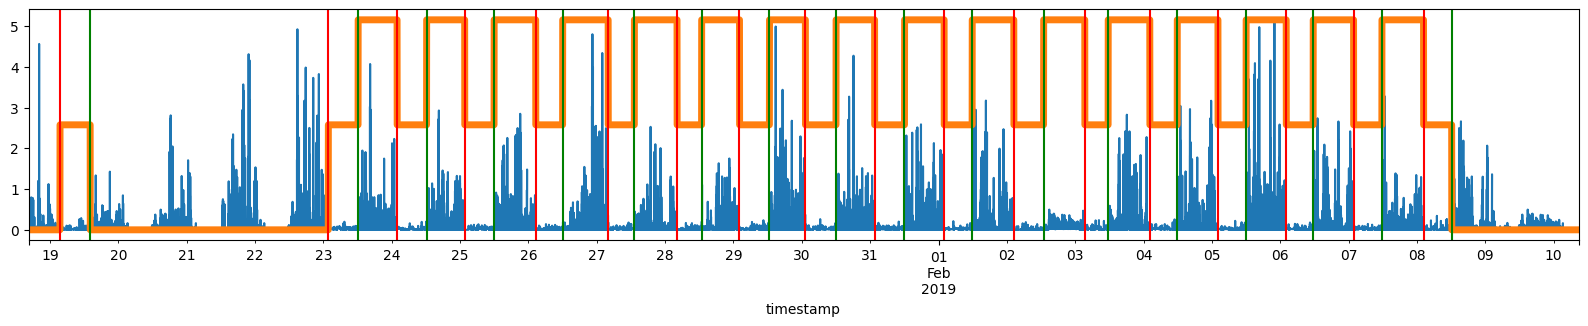


25e2b3dd9c3b


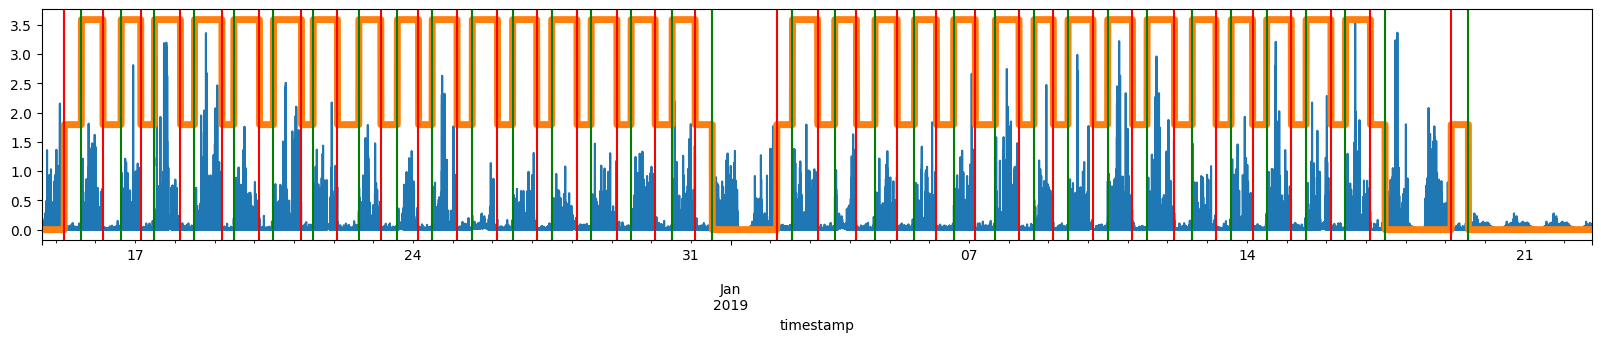


2654a87be968


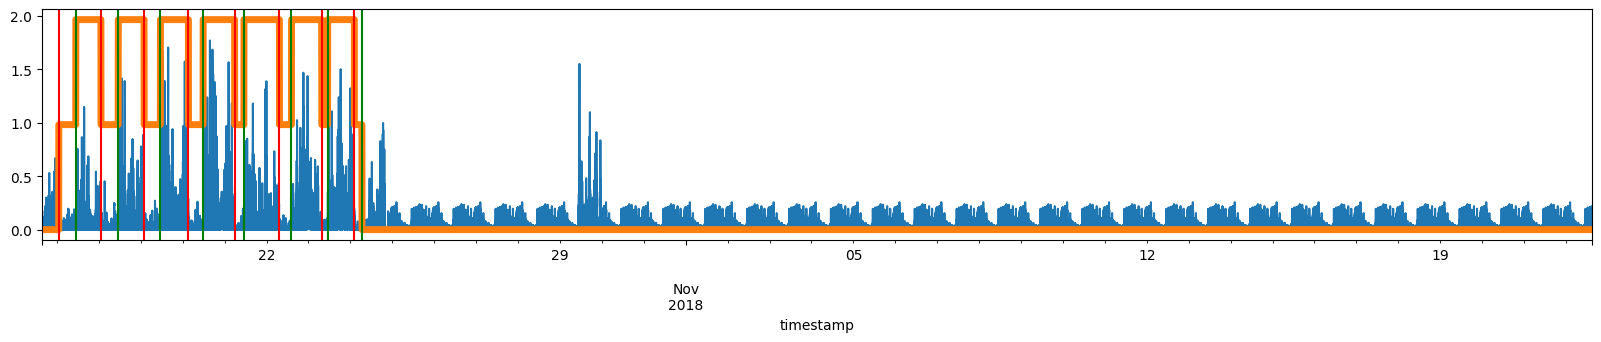


27f09a6a858f


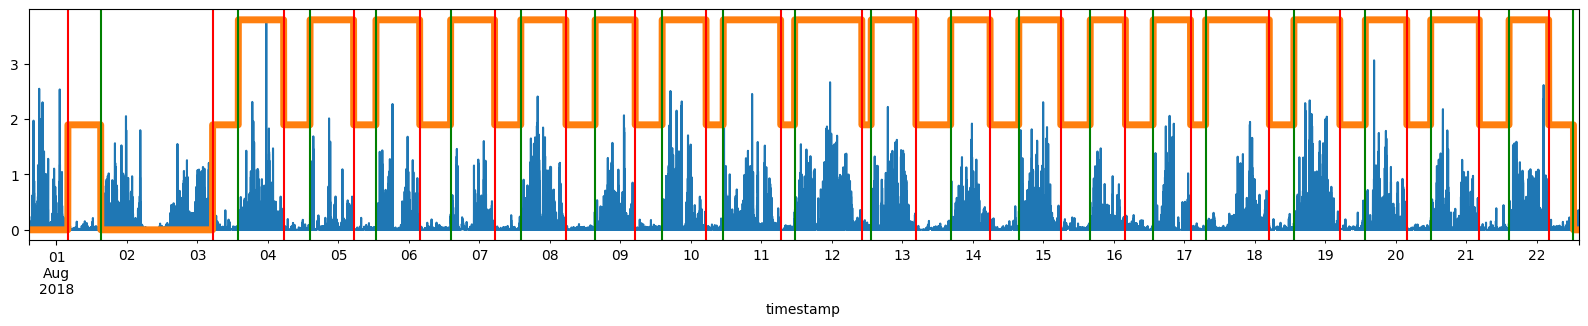


280e08693c6d


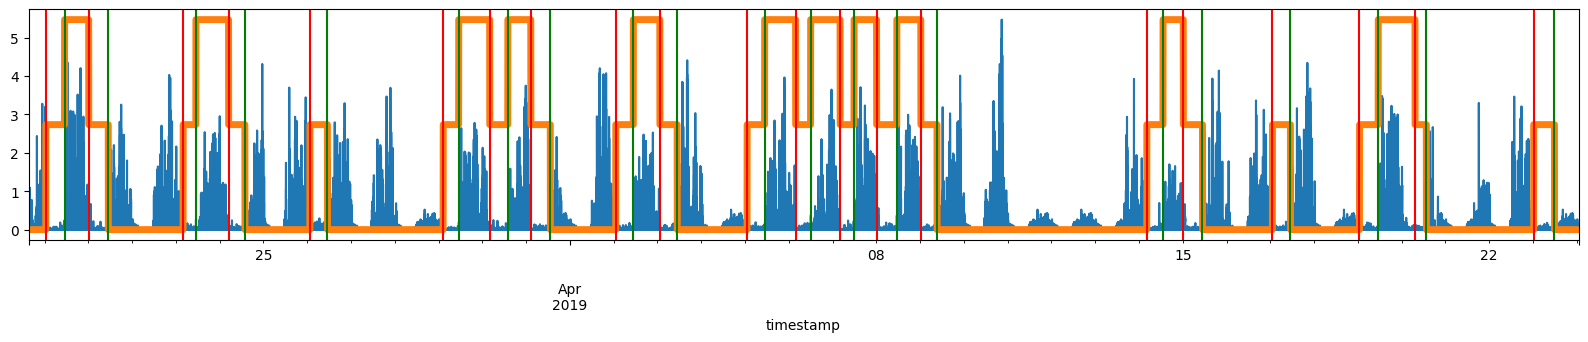


292a75c0b94e


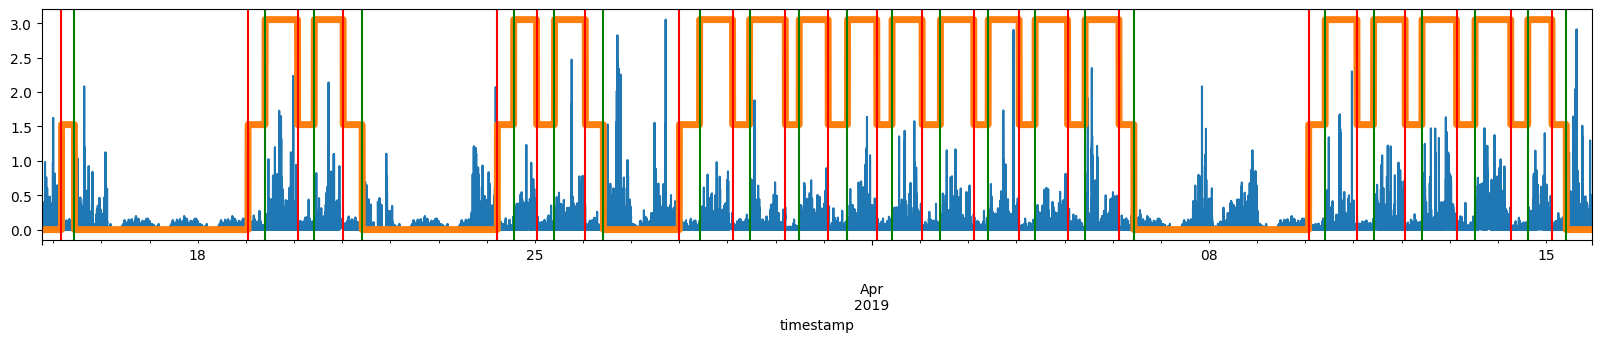


29c75c018220


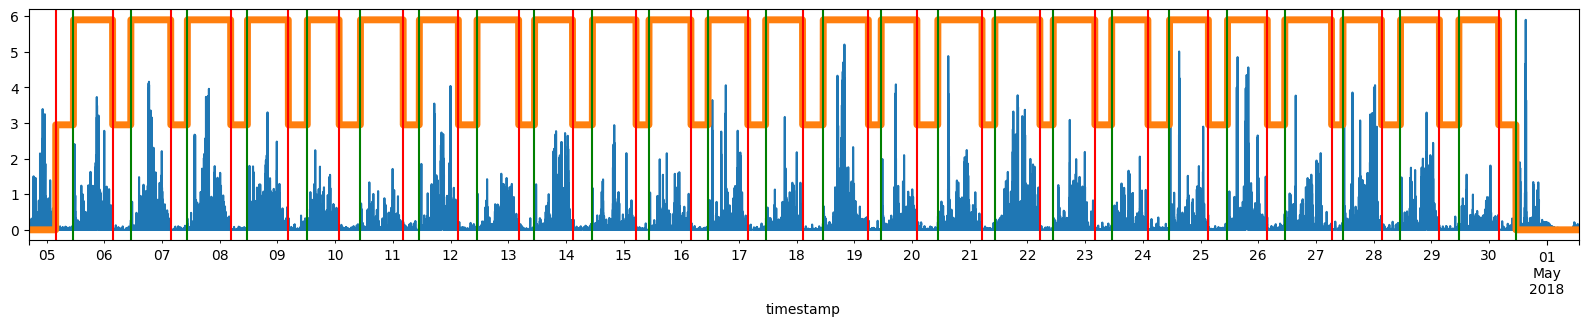


29d3469bd15d


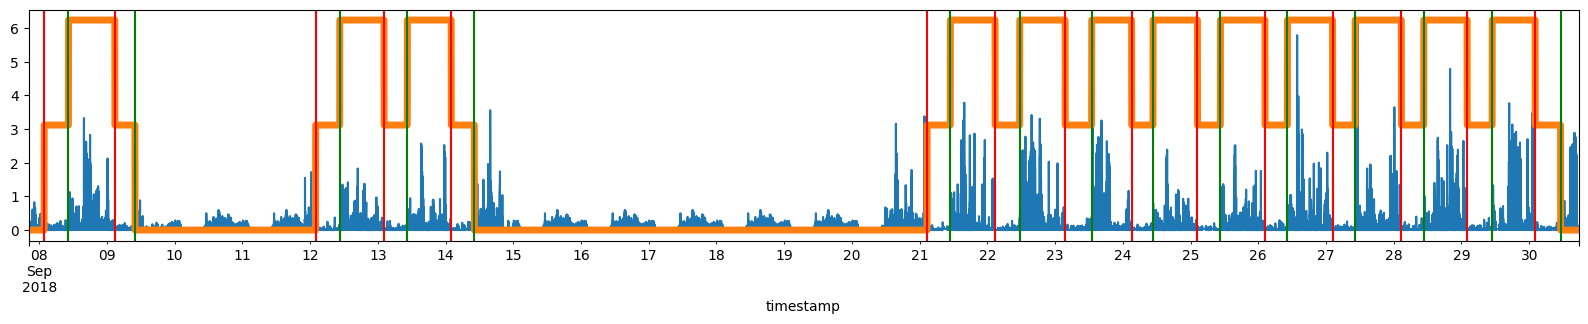


2b0a1fa8eba8


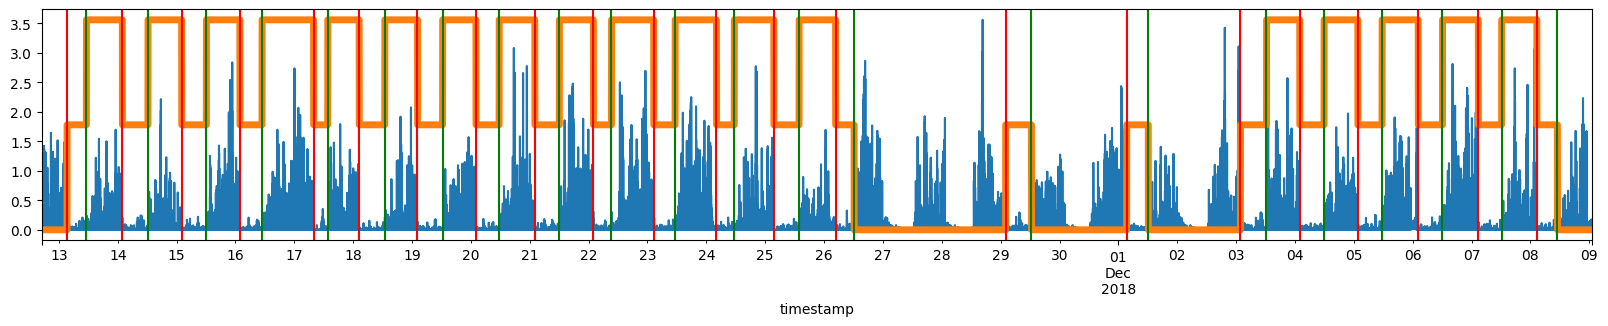


2b8d87addea9


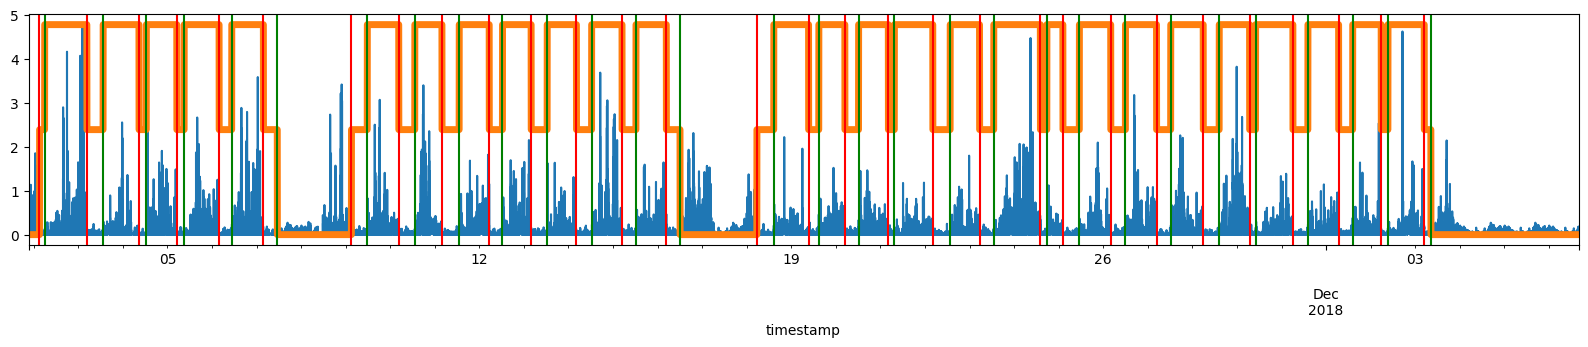


2cd2340ca14d


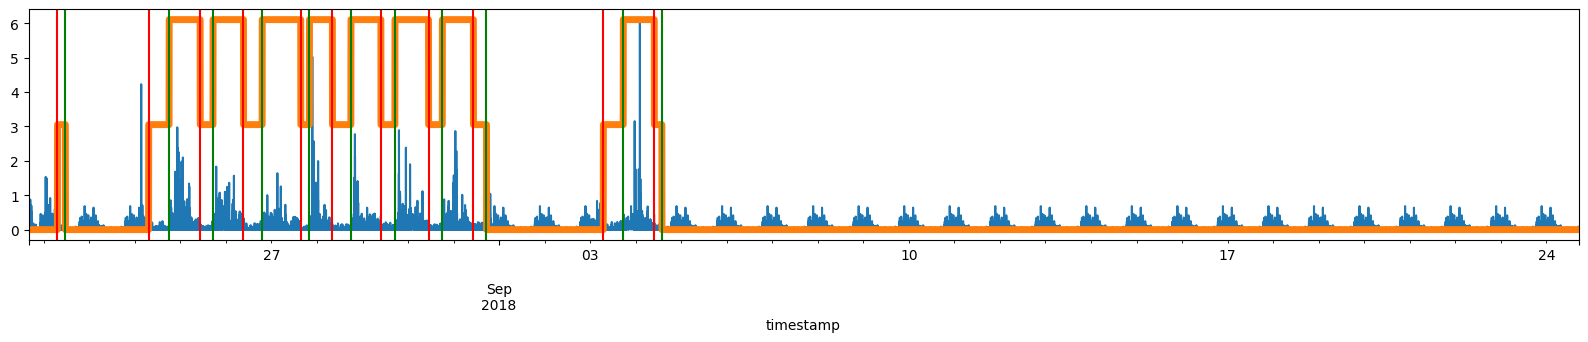


2e9ced2c7976


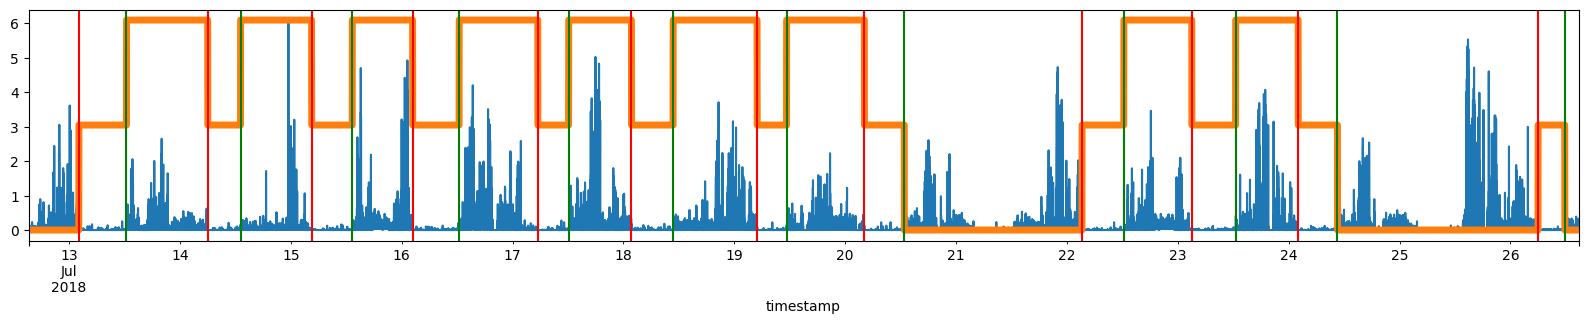


2f7504d0f426


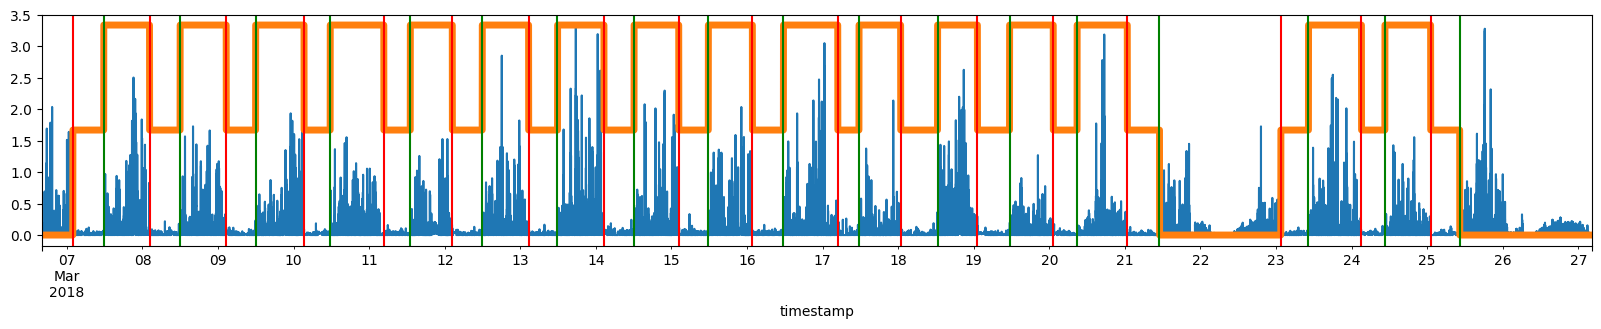


2fbbee1a38e3


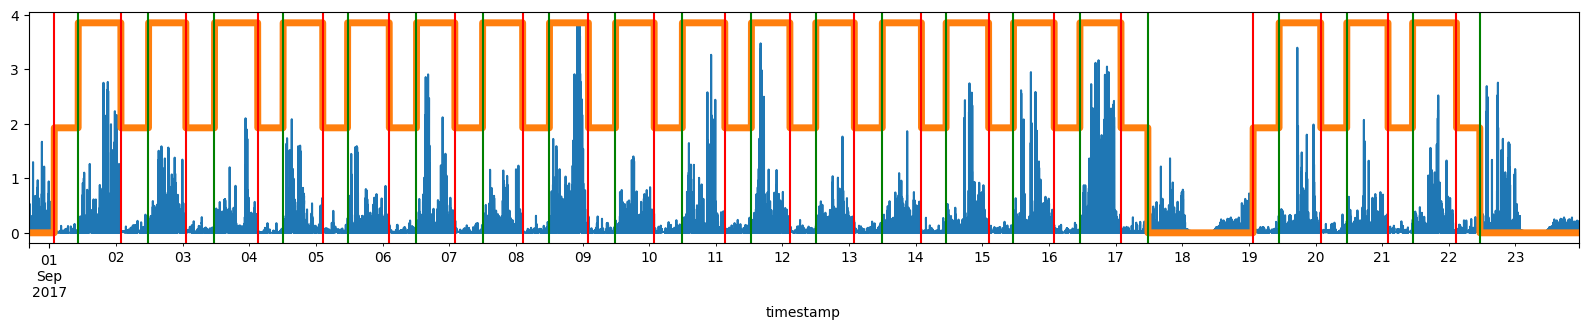


2fc653ca75c7


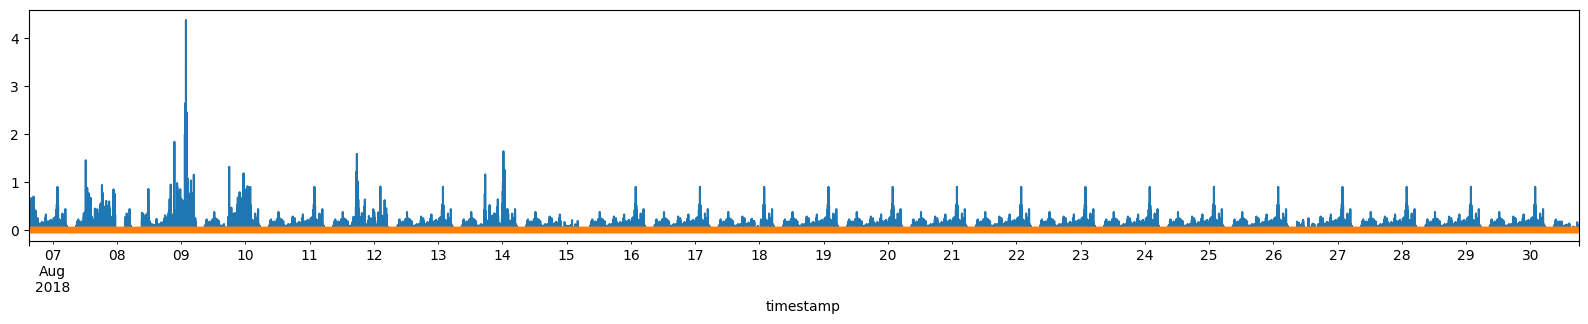


31011ade7c0a


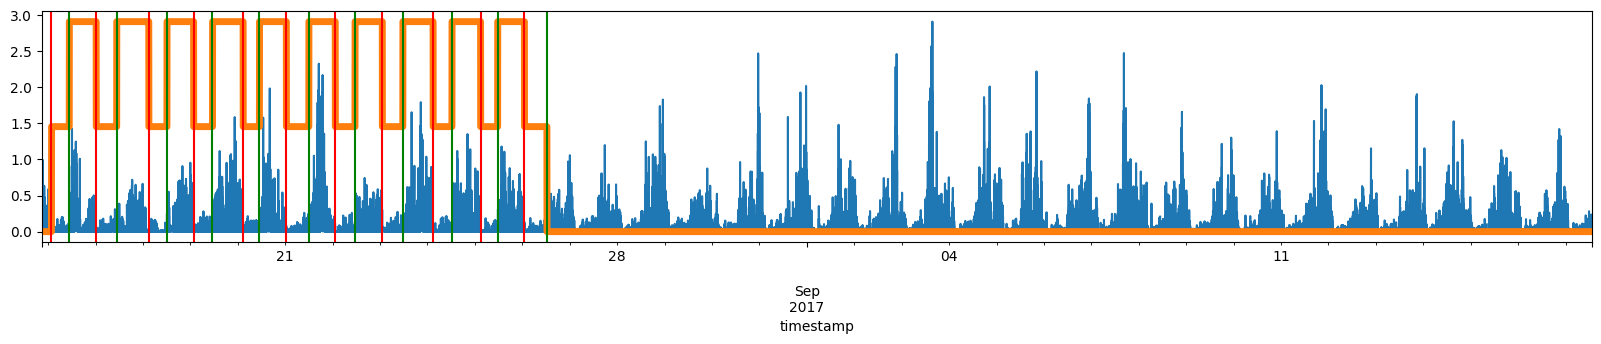


3318a0e3ed6f


KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt

new_train_series_list = {}
for series_id in series_ids:
    print('\n'+'='*50)
    print(series_id)
    
    _train_series = train_series[train_series['series_id']==series_id]
    _train_events = train_events[train_events['series_id']==series_id]
    
    _train_series.index = pd.to_datetime(_train_series['timestamp'], utc=True)
    _train_events.index = pd.to_datetime(_train_events['timestamp'], utc=True)
    
    _train_series = _train_series.assign(awake=-1, event_id=-1, night=0)
    
    current_event_time = _train_series.index[0]
    for _event_id, _events in enumerate(_train_events.itertuples()):
        _event = 0 if _events.event=='onset' else 1
        if _event_id == (len(_train_events)-1):
            _event = -1
        
        if not pd.isnull(_events.step):
            _train_series.loc[_train_series.index>=_events.Index, ['awake']] = _event
            current_event_time = _events.Index
        else:
            _train_series.loc[_train_series.index>=current_event_time, ['awake']] = -1
        _train_series.loc[_train_series.index>=_events.Index, ['event_id']] = _event_id
        _train_series.loc[_train_series.index>=_events.Index, ['night']] = _events.night
        
    new_train_series_list[series_id] = _train_series.copy()
    
    fig, ax = plt.subplots(figsize=(20, 3))
    _plot_series = _train_series['enmo']
    _plot_series.plot(ax=ax)
    (_train_series['awake']*_plot_series.abs().max()*0.5+_plot_series.abs().max()*0.5).plot(ax=ax, linewidth=5)
    for _time, _event in zip(_train_events.index, _train_events['event']):
        if not pd.isnull(_time):
            ax.axvline(x=_time, color='red' if _event=='onset' else 'green')
    plt.show()


In [6]:
# %%time
# import matplotlib.pyplot as plt
# import multiprocessing

# def process(series_id):
#     print(series_id)
    
#     _train_series = train_series[train_series['series_id']==series_id]
#     _train_events = train_events[train_events['series_id']==series_id]
    
#     _train_series.index = pd.to_datetime(_train_series['timestamp'], utc=True)
#     _train_events.index = pd.to_datetime(_train_events['timestamp'], utc=True)
    
#     _train_series = _train_series.assign(awake=-1, event_id=-1, night=0)
    
#     current_event_time = _train_series.index[0]
#     for _event_id, _events in enumerate(_train_events.itertuples()):
#         _event = 0 if _events.event=='onset' else 1
#         if not pd.isnull(_events.step):
#             _train_series.loc[_train_series.index>=_events.Index, ['awake']] = _event
#             current_event_time = _events.Index
#         else:
#             _train_series.loc[_train_series.index>current_event_time, ['awake']] = -1
#         _train_series.loc[_train_series.index>=_events.Index, ['event_id']] = _event_id
#         _train_series.loc[_train_series.index>=_events.Index, ['night']] = _events.night

#     return _train_series.copy()

# with multiprocessing.Pool() as pool:
#     new_train_series_list = pool.map(process, series_ids)

In [7]:
# def plot_series(_train_series, col_name):
#     fig, ax = plt.subplots(figsize=(20, 3))
#     for _event_id in _train_series.event_id.unique():
#         _series = _train_series[_train_series['event_id']==_event_id]
#         _awake = _series.iloc[0]['awake']
#         if _awake==1:
#             _color = 'red'
#         elif _awake==0:
#             _color = 'blue'
#         elif _awake==-1:
#             _color = 'green'

#         _series[col_name].plot(color=_color, ax=ax)
#     plt.show()

In [8]:
# for series_id, _train_series in zip(series_ids, new_train_series_list):
#     print('\n'+'='*50)
#     print(series_id)
#     plot_series(_train_series, col_name='enmo')
    

In [9]:
# for series_id, _train_series in zip(series_ids, new_train_series_list):
#     print('\n'+'='*50)
#     print(series_id)
#     _train_series = _train_series.assign(enmo_1MIN=_train_series['enmo'].rolling('1MIN').mean())
#     plot_series(_train_series, col_name='enmo_1MIN')

In [10]:
# for series_id, _train_series in zip(series_ids, new_train_series_list):
#     print('\n'+'='*50)
#     print(series_id)
#     _train_series = _train_series.assign(enmo_1MIN=_train_series['enmo'].rolling('1MIN').max())
#     plot_series(_train_series, col_name='enmo_1MIN')
#     plt.show()

In [11]:
# for series_id, _train_series in zip(series_ids, new_train_series_list):
#     print('\n'+'='*50)
#     print(series_id)
#     _train_series = _train_series.assign(enmo_30MIN=_train_series['enmo'].rolling('30MIN').mean())
#     plot_series(_train_series, col_name='enmo_30MIN')
#     plt.show()

In [12]:
# for series_id, _train_series in zip(series_ids, new_train_series_list):
#     print('\n'+'='*50)
#     print(series_id)
#     _train_series = _train_series.assign(enmo_30MIN=_train_series['enmo'].rolling('30MIN').max())
#     plot_series(_train_series, col_name='enmo_30MIN')
#     plt.show()

In [13]:
# new_train_series = pd.concat(new_train_series_list)
# new_train_series

In [14]:
# new_train_series.to_csv("train_series_all.csv", index=False)

In [15]:
# new_train_series[new_train_series['awake']!=-1].to_csv("train_series.csv", index=False)

In [21]:
%pwd

'c:\\Users\\yashr\\OneDrive\\Desktop\\CMI_detect_sleep_states\\CMI-sleep-state-detection'

In [17]:
for series_id, _train_series in new_train_series_list.items():
    _train_series.to_csv("data/intermediate_data/train_series_{}.csv".format(series_id), index=False)

KeyboardInterrupt: 